In [16]:
from gptopt.optim.pdhg import *
from utils_pdhg import *

In [17]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

In [18]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 200

mu_scale = 0.1
betas = [0.1, 0.01, 0.001, 0.0001]

#  $m=n=1000$

In [19]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)

lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}")

A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4881e-01, fro_norm=7.0724e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4729e-01, fro_norm=7.0803e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1526e-01, fro_norm=1.2542e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1548e-01, fro_norm=1.2543e+00
lamb_max=3.7620e+00


In [20]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
    mu_reg = max(mu_scale * mu_max, 1e-6)
    print(f"{lamb_max=:.4e}, {mu_max=:.4e}")
    residuals[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=3.7620e+00, mu_max=2.0508e-02
lamb_max=10.007453778397428
obj (diag scaling):  -102.80094146728516 
constraint viol (diag scaling):  0.0
lamb_max=10.007453778397428
obj (vanilla):  -59.78693389892578 
constraint viol (vanilla):  0.0
lamb_max=10.007453778397428
obj (acceleration):  -58.65810775756836 
constraint viol (acceleration):  0.0


obj (fista):  -636.7476806640625 
constraint viol (fista):  0.05693288147449488
lamb_max=3.7620e+00, mu_max=2.0508e-01
lamb_max=10.007453778397428
obj (diag scaling):  -51.831321716308594 
constraint viol (diag scaling):  0.4479155652225017
lamb_max=10.007453778397428
obj (vanilla):  -41.14971160888672 
constraint viol (vanilla):  0.30808521062135696
lamb_max=10.007453778397428
obj (acceleration):  -37.131046295166016 
constraint viol (acceleration):  0.23589560389518735
obj (fista):  -63.674781799316406 
constraint viol (fista):  0.05693247169256208
lamb_max=3.7620e+00, mu_max=2.0508e+00
lamb_max=10.007453778397428
obj (diag scaling):  -6.374154090881348 
constraint viol (diag scaling):  0.18647154886275527
lamb_max=10.007453778397428
obj (vanilla):  -6.303117275238037 
constraint viol (vanilla):  0.5278132632374763
lamb_max=10.007453778397428
obj (acceleration):  -6.095694065093994 
constraint viol (acceleration):  0.5040566213428974
obj (fista):  -6.367477893829346 
constraint viol 

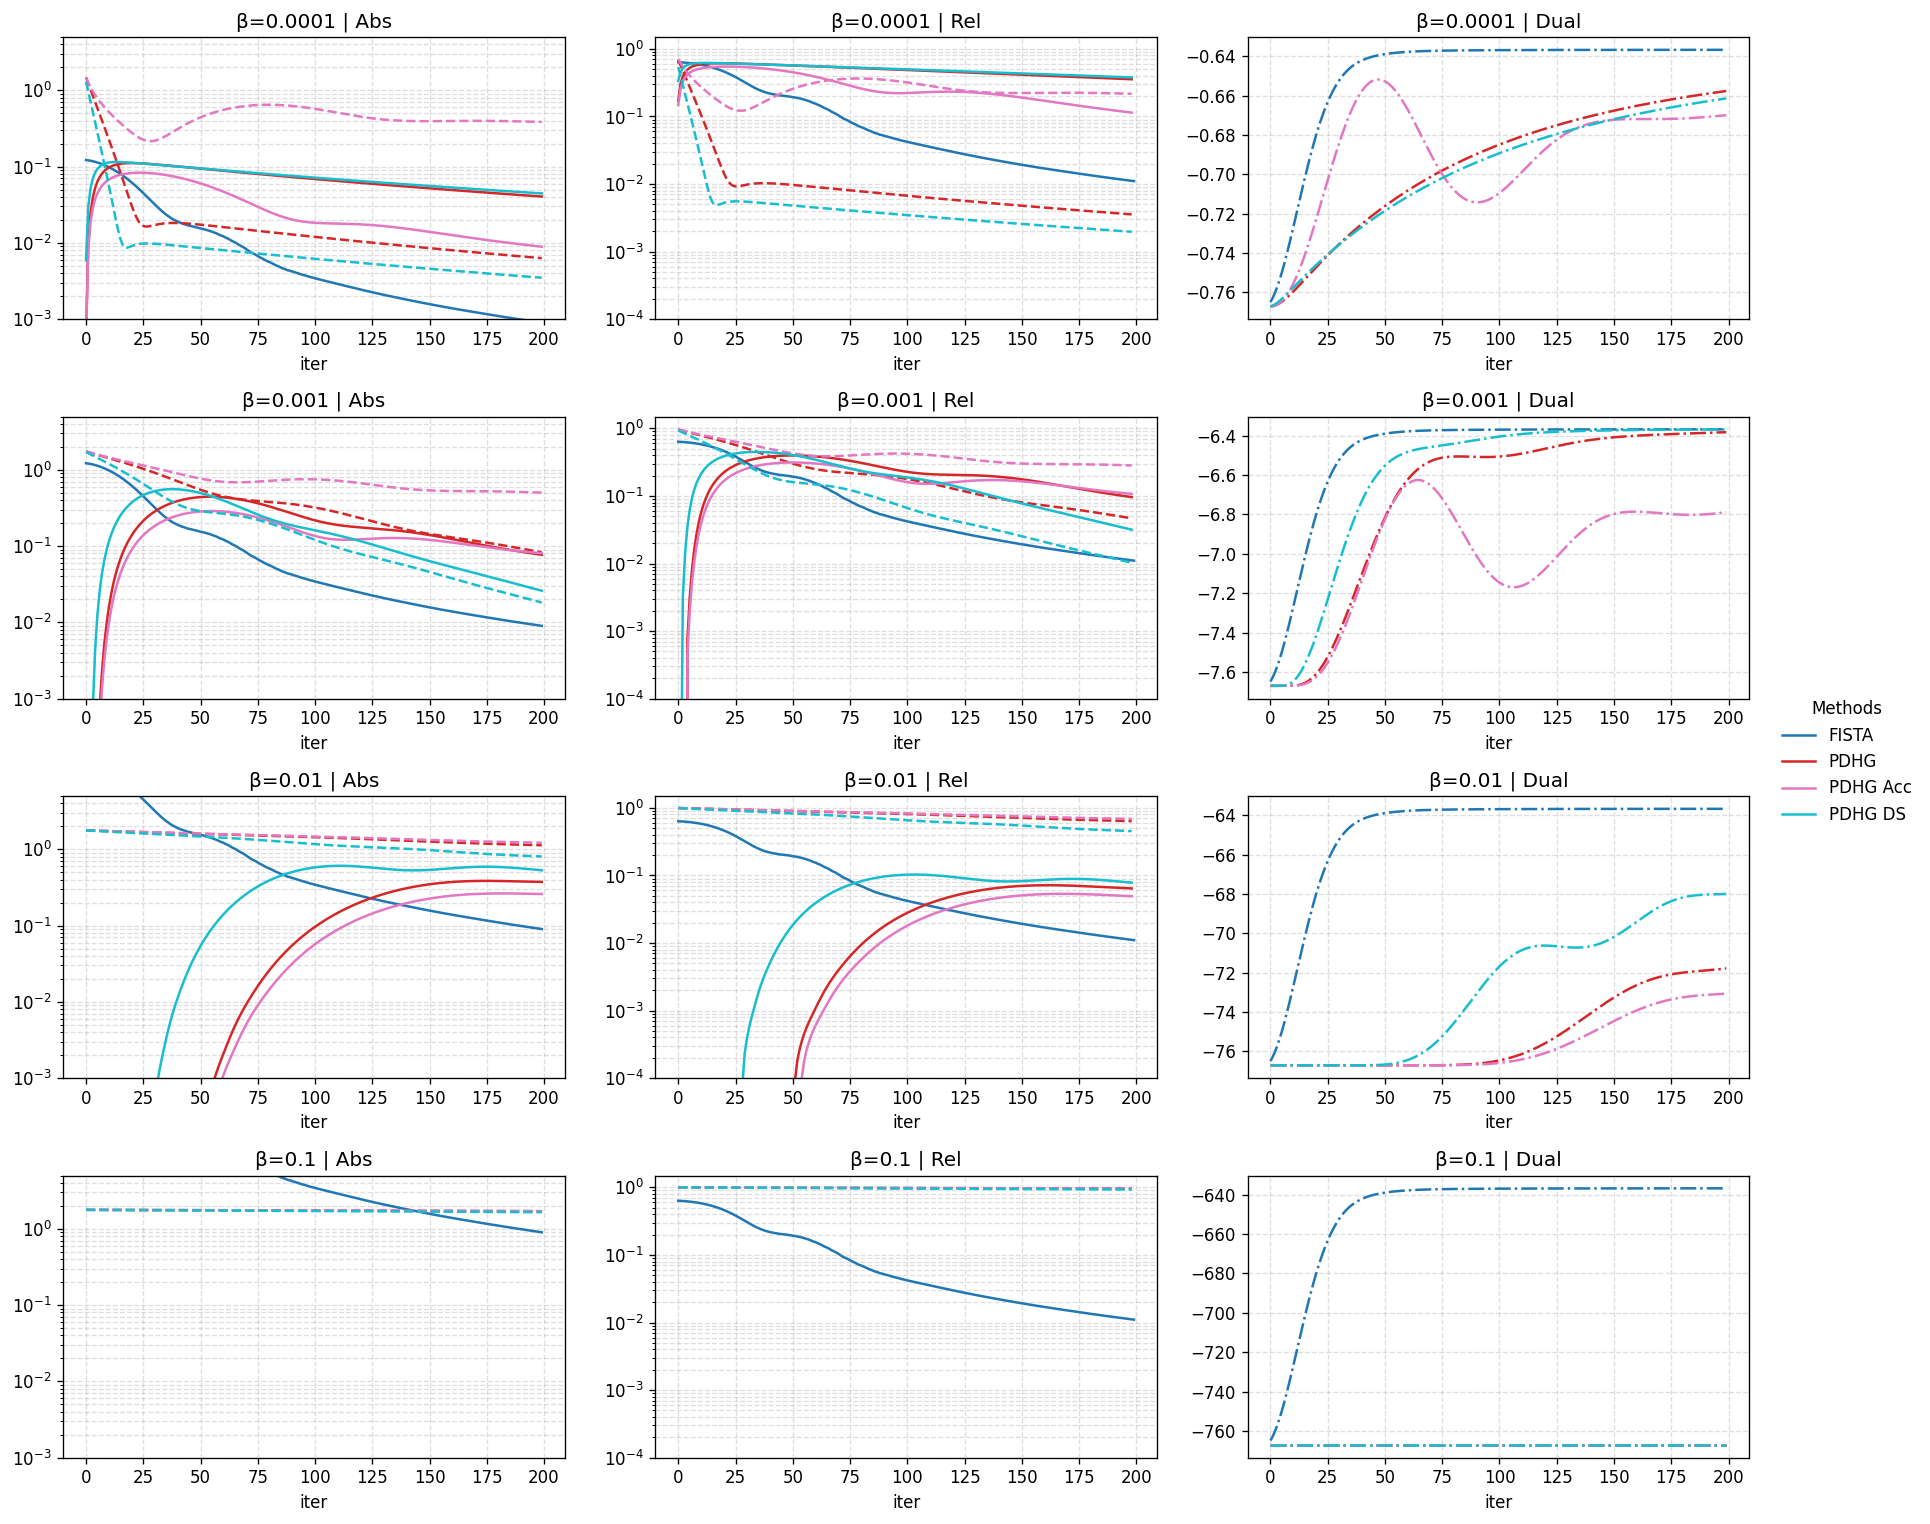

In [23]:
_ = plot_residuals_grid_by_param(residuals, abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), param_name='beta')

#  $m=n=1000$

In [7]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)


nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4532e-01, fro_norm=7.0719e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4607e-01, fro_norm=7.0739e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1579e-02, fro_norm=1.2538e-01
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1613e-02, fro_norm=1.2541e-01
mu_reg=2.0508e+00, lamb_max=1.0003e+01, mu_max=2.0508e+01


In [8]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
    mu_reg = max(mu_scale * mu_max, 1e-6)
    print(f"{lamb_max=:.4e}, {mu_max=:.4e}")
    residuals[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=1.0003e+01, mu_max=1.9215e-03
lamb_max=10.002639502026655
obj (diag scaling):  -1.0966070890426636 
constraint viol (diag scaling):  0.0
lamb_max=10.002639502026655
obj (vanilla):  -0.6201529502868652 
constraint viol (vanilla):  0.0
lamb_max=10.002639502026655
obj (acceleration):  -0.6189911961555481 
constraint viol (acceleration):  0.0
obj (fista):  -66.29133605957031 
constraint viol (fista):  0.43544808030128473
lamb_max=1.0003e+01, mu_max=1.9215e-02
lamb_max=10.002639502026655
obj (diag scaling):  -1.0326085090637207 
constraint viol (diag scaling):  0.0
lamb_max=10.002639502026655
obj (vanilla):  -0.5993837118148804 
constraint viol (vanilla):  0.0
lamb_max=10.002639502026655
obj (acceleration):  -0.5887278914451599 
constraint viol (acceleration):  0.0
obj (fista):  -6.629134178161621 
constraint viol (fista):  0.4354411512613296
lamb_max=1.0003e+01, mu_max=1.9215e-01
lamb_max=10.002639502026655
obj (diag scaling):  -0.5338701009750366 
constraint viol (diag scaling): 

obj (vanilla):  -0.4200409948825836 
constraint viol (vanilla):  0.3279520208016038
lamb_max=10.002639502026655
obj (acceleration):  -0.38041406869888306 
constraint viol (acceleration):  0.2433956144377589
obj (fista):  -0.6629133820533752 
constraint viol (fista):  0.4354280428960919
lamb_max=1.0003e+01, mu_max=1.9215e+00
lamb_max=10.002639502026655
obj (diag scaling):  -0.06707248091697693 
constraint viol (diag scaling):  0.2149661779403686
lamb_max=10.002639502026655
obj (vanilla):  -0.06625326722860336 
constraint viol (vanilla):  0.526450942037627
lamb_max=10.002639502026655
obj (acceleration):  -0.0638832300901413 
constraint viol (acceleration):  0.5390384942293166
obj (fista):  -0.06629133969545364 
constraint viol (fista):  0.43543540616519744


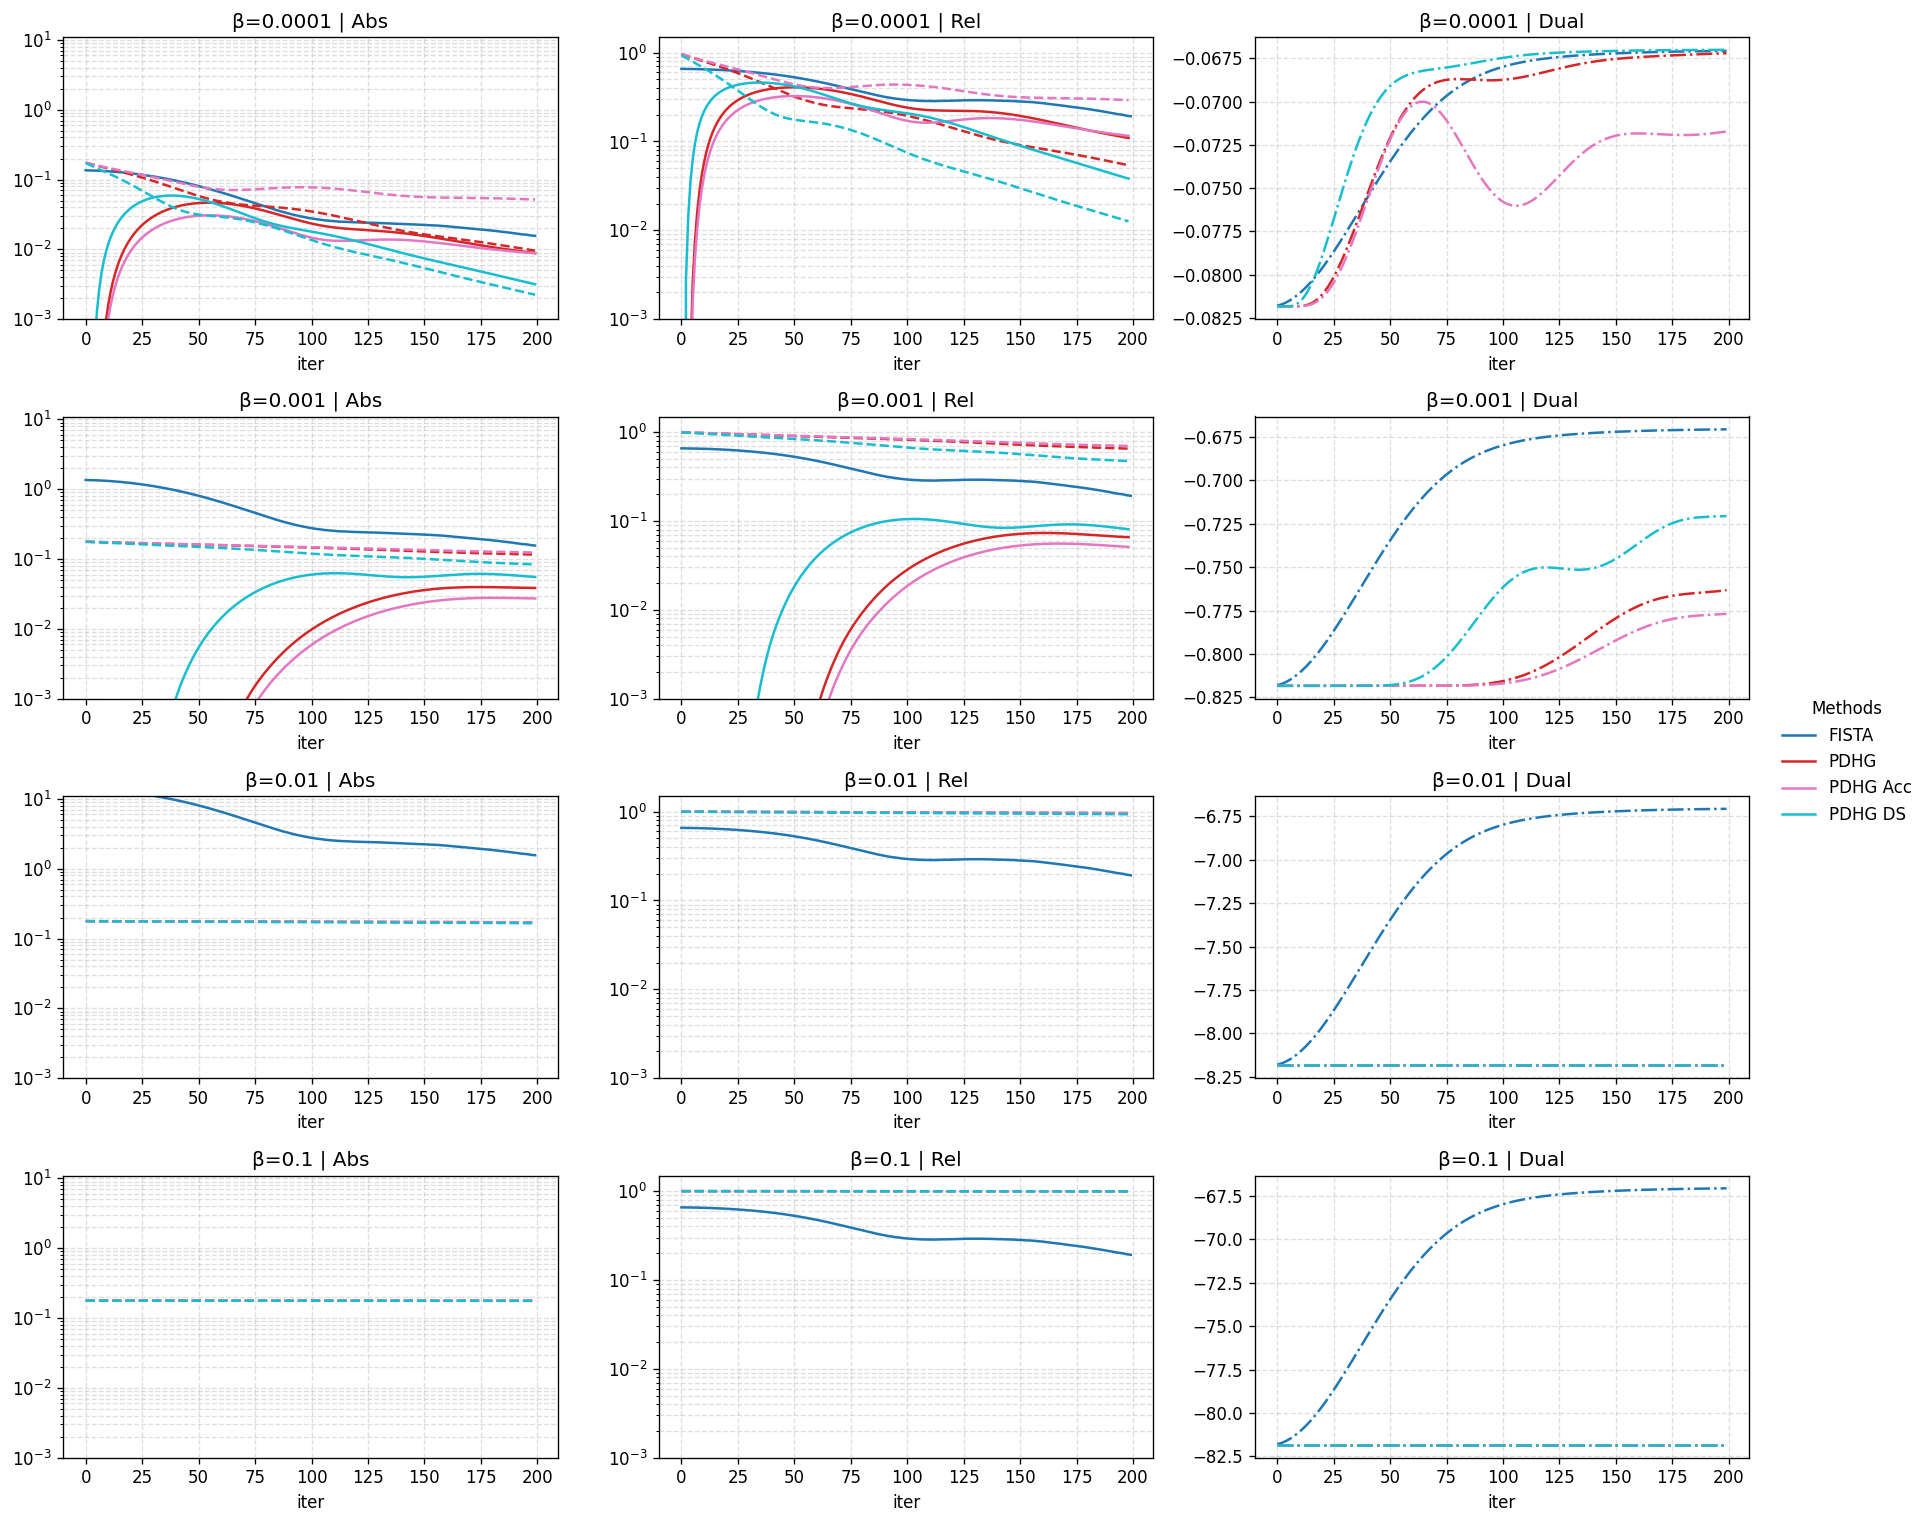

In [15]:
_ = plot_residuals_grid_by_param(residuals, abs_ylim=(1e-3, 11), rel_ylim=(1e-3, 1.5), param_name='beta')